# Setting

In [1]:
from pf_utils import PortfolioManager as PM 
from pf_utils import BacktestManager
from pf_widgets import WidgetUniverse, WidgetTransaction

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
path_data = 'data'

# Universe

In [6]:
PM.review('universe')

Universe: UV_K200, UV_KRX, UV_LIQ, UV_WTR, UV_ETF, UV_IRP, UV_HANA, UV_FCTR


In [7]:
PM.review_universe('UV_K200')

{'universe': 'kospi200',
 'file': 'kospi200_prices',
 'upload_type': 'price',
 'path': 'data'}

In [8]:
WidgetUniverse

## KRX

In [9]:
krx = PM.create_universe('UV_KRX')

2712 assets from 2019-01-02 to 2024-10-08 uploaded.
df_prices loaded


In [42]:
kw = dict(
    n_years=3, 
    close_today = WidgetUniverse.values(1),
    interval=5, pause_duration=1, msg=False
)
#krx.download(**kw) if WidgetUniverse.values(0) else None

In [10]:
df_krx = krx.df_prices
assetnames_krx = krx.get_names()

ERROR from get_names: '287410'


### KOSPI

In [11]:
from pf_utils import KRXDownloader
market = 'KOSPI'
krxd = KRXDownloader(None)
krxd.get_tickers(market)
assets_kospi = krxd.tickers

In [12]:
df_kospi = df_krx[df_krx.columns.intersection(assets_kospi)]

## K200

*Approximate historicals of KOSPI200 for bactesting*

In [ ]:
file = 'bt_kospi200_prices_040102_241023'

In [ ]:
k200 = PM.create_universe('UV_K200', file=file)

426 assets from 2004-01-02 to 2024-10-23 uploaded.
df_prices loaded


In [16]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

ERROR from get_names: '060000'


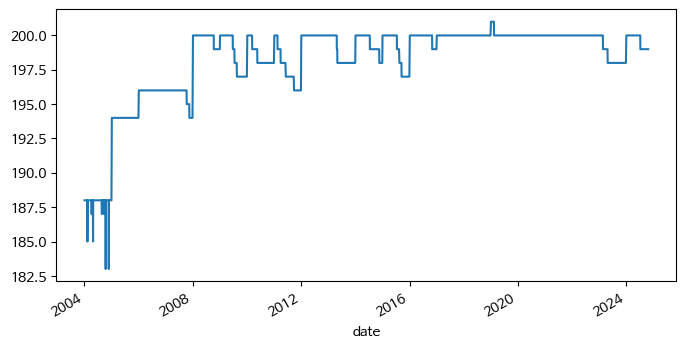

In [18]:
_ = df_k200.notna().sum(axis=1).plot(figsize=(8,4))

*stocks remaining in the universe to track portfolio positions*

In [19]:
cond = (df_k200.ffill() != df_k200).sum() == 0
cond.sum() / df_k200.columns.size

0.14084507042253522

In [20]:
df_k200 = df_k200.ffill()

# Parameter Study

## KOSPI

In [25]:
krx.get_date_range().describe()

,start date,end date,n
count,2712,2712,2712.000000
mean,2019-09-21 09:34:30.796460288,2024-10-08 00:00:00,1242.557153
min,2019-01-02 00:00:00,2024-10-08 00:00:00,5.000000
25%,2019-01-02 00:00:00,2024-10-08 00:00:00,1420.000000
50%,2019-01-02 00:00:00,2024-10-08 00:00:00,1420.000000
75%,2019-01-02 00:00:00,2024-10-08 00:00:00,1420.000000
max,2024-09-30 00:00:00,2024-10-08 00:00:00,1420.000000
std,NaN,NaN,379.045882


In [27]:
n_val = 200
n_lb = 260
df = df_kospi
df_train = df.iloc[:-n_val]
df_val = df.iloc[-n_val-n_lb:]

In [28]:
kwargs_bm = dict(
    initial_capital = 1e8,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_krx
)

### Cross-validate

In [29]:
from itertools import product

p_args = dict(
    p_n_assets = [5, 10, 20],
    p_lookback = ['6m', '1y'],
    p_lag = ['1w', '1m'],
    p_freq = ['1m']
)

p_comb = list(product(*p_args.values()))
params = [{'name':f'MMT:n{x[0]}/lb{x[1]}/lg{x[2]}/f{x[3]}',
           'n_assets':x[0], 'lookback':x[1], 'lag':x[2], 'freq':x[3]} 
            for x in p_comb]
params[0]

{'name': 'MOM:n5/lb6m/lg1w/f1m',
 'n_assets': 5,
 'lookback': '6m',
 'lag': '1w',
 'freq': '1m'}

In [30]:
bm = BacktestManager(df_train, **kwargs_bm)

946 assets from 2019-01-02 to 2023-12-08 uploaded.
running self.util_check_days_in_year to check days in a year


In [31]:
kwa_list = params
kwargs_build = dict(
    select='Momentum', weigh='Equally', 
    reset_portfolios=True, build_cv=True
)
bm.build_batch(*kwa_list, **kwargs_build)

12 jobs prepared for cross-validation


In [80]:
kw_batch = dict(size_batch=6, path_batch=path_data)
bm.cross_validate(n_sample=20, **kw_batch)

Cross-validating 12 strategies: MOM:n5/lb6m/lg1w/f1m, MOM:n5/lb6m/lg1m/f1m, ... , MOM:n20/lb1y/lg1m/f1m


100%|███████████████████████████████████████████████████████████████| 18/18 [01:05<00:00,  3.64s/it]


12.4 mins elapsed, 0.0 secs paused (0.0%)
Temp batch files deleted


### Visualize

In [81]:
file = 'param_momentum_kospi.csv'

In [82]:
f = dict(file=file, path=path_data)
df_cv = bm.get_cat_data(params, **f)

data/param_momentum_kospi.csv saved
12 param sets with 18 iterations per set


*Load param study*

In [83]:
bm = BacktestManager
df_cv = bm.catplot(file, path=path_data)

Returning data/param_momentum_kospi.csv
12 param sets with 18 iterations per set


In [37]:
y = 'cagr'
ref_val = bm.benchmark_stats(y, data=df_cv, name='KODEX200')

Returning cagr of KODEX200 from 2019-01-02 to 2023-12-08


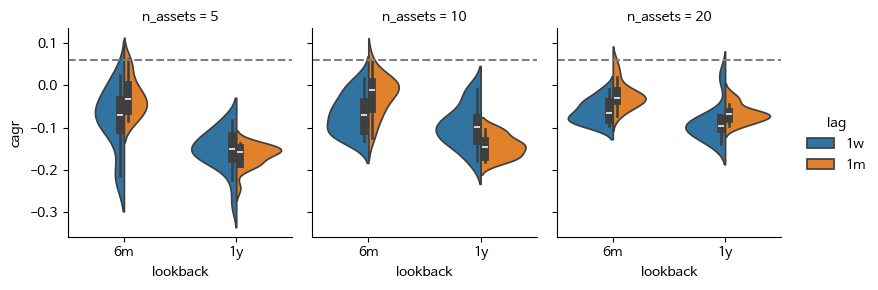

In [84]:
#kw = {'x':'n_assets', 'col':'lookback', 'hue':'lag'}
kw = {'col':'n_assets', 'x':'lookback', 'hue':'lag', 'kind':"violin", 'split':True}

_ = bm.catplot(data=df_cv, y=y, ref_val=ref_val, height=3, aspect=.9, **kw)

### Validation

In [85]:
bm = BacktestManager(df_val, **kwargs_bm)

lags = dict(lookback='6m', lag='1m')
bm.benchmark_ticker(**lags)

946 assets from 2022-11-22 to 2024-10-08 uploaded.
running self.util_check_days_in_year to check days in a year
Benchmark is KODEX200


In [86]:
# n_assets, lookback(M), lag(D), freq(D)
p_comb = [[10, '6m', '1m', '1m'], [20, '1y', '1m', '1m']]
kwa_list = [{'name':f'MMT:n{x[0]}/lb{x[1]}/lg{x[2]}/f{x[3]}',
           'n_assets':x[0], 'lookback':x[1], 'lag':x[2], 'freq':x[3]} 
            for x in p_comb]

Backtesting 3 strategies: KODEX200, MOM:n10/lb6m/lg1m/f1m, MOM:n20/lb1y/lg1m/f1m


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]

Returning stats


,KODEX200,MOM:n20/lb1y/lg1m/f1m,MOM:n10/lb6m/lg1m/f1m
start,2022-11-21,2022-11-21,2022-11-21
end,2024-10-08,2024-10-08,2024-10-08
total_return,0.044089,-0.008074,-0.498245
cagr,0.023203,-0.004301,-0.306951
calmar,0.140809,-0.013987,-0.520896
max_drawdown,-0.164786,-0.307458,-0.589276
avg_drawdown,-0.031322,-0.058966,-0.306594
avg_drawdown_days,21.45,18.230769,223.0
daily_vol,0.161285,0.225115,0.351427
daily_sharpe,0.227874,0.093818,-0.898448


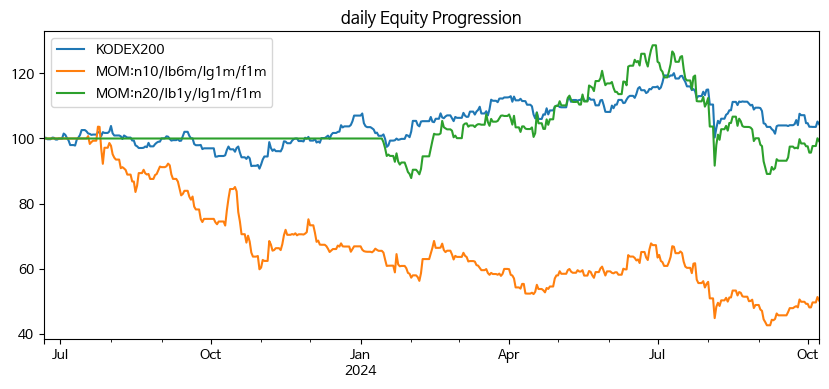

In [87]:
kwargs_build = dict(
    select='Momentum', weigh='Equally'
)
bm.build_batch(*kwa_list, **kwargs_build)

bm.run(stats_sort_by='cagr', figsize=(10,4))

## K200

In [34]:
k200.get_date_range().describe()

,start date,end date,n
count,426,426,426.000000
mean,2009-02-07 17:34:38.873239552,2019-06-30 14:21:58.309859328,2392.565728
min,2004-01-02 00:00:00,2004-12-30 00:00:00,34.000000
25%,2004-01-02 00:00:00,2014-12-30 00:00:00,745.500000
50%,2005-01-03 00:00:00,2023-03-23 12:00:00,1987.000000
75%,2014-01-02 00:00:00,2024-10-23 00:00:00,3911.000000
max,2024-01-02 00:00:00,2024-10-23 00:00:00,5142.000000
std,NaN,NaN,1737.626557


In [35]:
df = df_k200
n_val = 500
n_lb = 260
df_train = df.iloc[:-n_val]
df_val = df.iloc[-n_val-n_lb:]

In [36]:
kwargs_bm = dict(
    initial_capital = 1e8,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_k200
)

### Cross-validate

In [37]:
from itertools import product

p_args = dict(
    p_n_assets = [5, 10, 20],
    p_lookback = ['3m', '6m', '1y'],
    p_lag = ['1w', '2w', '1m'],
    p_freq = ['1m', '1q']
)
p_comb = list(product(*p_args.values()))
params = [{'name':f'MMT:n{x[0]}/lb{x[1]}/lg{x[2]}/f{x[3]}',
           'n_assets':x[0], 'lookback':x[1], 'lag':x[2], 'freq':x[3]} 
            for x in p_comb]
params[0]

{'name': 'MOM:n5/lb3m/lg1w/f1m',
 'n_assets': 5,
 'lookback': '3m',
 'lag': '1w',
 'freq': '1m'}

In [38]:
bm = BacktestManager(df_train, **kwargs_bm)

426 assets from 2004-01-02 to 2022-10-07 uploaded.
running self.util_check_days_in_year to check days in a year


In [39]:
kwa_list = params
kwargs_build = dict(
    select='Momentum', weigh='Equally', 
    reset_portfolios=True, build_cv=True
)
bm.build_batch(*kwa_list, **kwargs_build)

54 jobs prepared for cross-validation


In [16]:
kw_batch = dict(size_batch=5, path_batch=path_data)
bm.cross_validate(n_sample=20, **kw_batch)

Cross-validating 54 strategies: MOM:n5/lb3m/lg1w/f1m, MOM:n5/lb3m/lg1w/f1q, ... , MOM:n20/lb1y/lg1m/f1q
Make sure 35 jobs done before


100%|███████████████████████████████████████████████████████████████| 19/19 [05:02<00:00, 15.94s/it]


89.1 mins elapsed, 0.0 secs paused (0.0%)
Temp batch files deleted


### Visualize

In [40]:
file = 'param_momentum_k200.csv'

*Save param study*

In [18]:
f = dict(file=file, path=path_data)
df_cv = bm.get_cat_data(params, **f)

data/param_momentum_k2hl.csv saved
54 param sets with 17 iterations per set


*Load param study*

In [41]:
bm = BacktestManager
df_cv = bm.catplot(file, path=path_data)

Returning data/param_momentum_k200.csv
54 param sets with 17 iterations per set


In [42]:
y = 'cagr'
ref_val = bm.benchmark_stats(y, data=df_cv, name='KODEX200')

Returning cagr of KODEX200 from 2004-01-02 to 2022-10-07


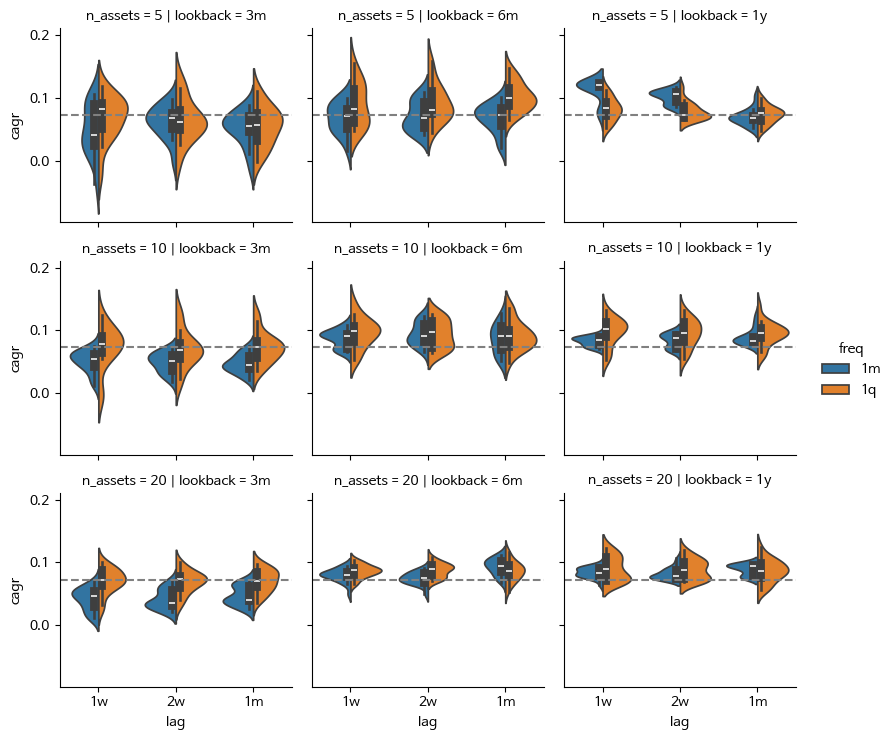

In [43]:
#kw = {'x':'freq', 'row':'n_assets', 'col':'lookback'}
#kw = {'x':'lookback', 'row':'freq', 'col':'n_assets', 'kind':'box'}
kw = {'col':'lookback', 'hue':'freq', 'row':'n_assets', 'x':'lag', 'kind':"violin", 'split':True}

_ = bm.catplot(data=df_cv, y=y, ref_val=ref_val, height=2.5, aspect=1.1, **kw)

### Validation

In [44]:
bm = BacktestManager(df_val, **kwargs_bm)

lags = dict(lookback='1y', lag='1w')
bm.benchmark_ticker(**lags)

426 assets from 2021-09-15 to 2024-10-23 uploaded.
running self.util_check_days_in_year to check days in a year
Benchmark is KODEX200


In [45]:
# n_assets, lookback(M), lag(D), freq(D)
p_comb = [[5, '1y', '1w', '1m'], [20, '1y', '1m', '1m']]
kwa_list = [{'name':f'MMT:n{x[0]}/lb{x[1]}/lg{x[2]}/f{x[3]}',
           'n_assets':x[0], 'lookback':x[1], 'lag':x[2], 'freq':x[3]} 
            for x in p_comb]

Backtesting 3 strategies: KODEX200, MOM:n5/lb1y/lg1w/f1m, MOM:n20/lb1y/lg1m/f1m


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.28it/s]

Returning stats


,MOM:n5/lb1y/lg1w/f1m,MOM:n20/lb1y/lg1m/f1m,KODEX200
start,2021-09-14,2021-09-14,2021-09-14
end,2024-10-23,2024-10-23,2024-10-23
total_return,0.277334,0.259325,0.194647
cagr,0.081956,0.077023,0.058903
calmar,0.21034,0.312743,0.357456
max_drawdown,-0.389634,-0.246282,-0.164784
avg_drawdown,-0.08192,-0.061558,-0.034156
avg_drawdown_days,63.181818,56.0,25.333333
daily_vol,0.282508,0.178339,0.151278
daily_sharpe,0.428507,0.5182,0.465926


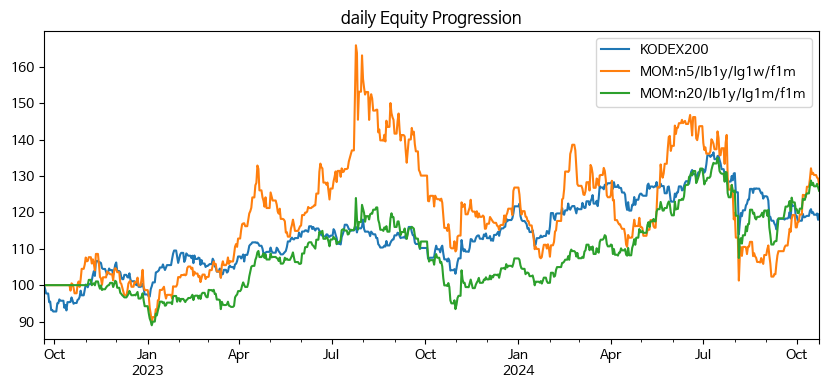

In [46]:
kwargs_build = dict(
    select='Momentum', weigh='Equally'
)
bm.build_batch(*kwa_list, **kwargs_build)

bm.run(stats_sort_by='cagr', figsize=(10,4))